# Tensorflow practice C3W3

In [7]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [8]:
embedding_dim=100
max_length=16
trunc_type='post'
padding_type='post'
oov_tok='<oov>'
training_size=160000
test_portion=.1

corpus=[]

In [9]:
#download data

!gdown --id 1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ

num_sentences=0

with open('./training_cleaned.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    #list_item = [[문장], [label값]] -> 이걸 corpus에 append
    for row in reader:
        list_item = []
        
        list_item.append(row[5])
#         print(row[5], row[0])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        
        num_sentences = num_sentences + 1
        corpus.append(list_item)

Downloading...
From: https://drive.google.com/uc?id=1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ
To: /Users/jinwooahn/Documents/dev_folder/2021_2nd_semester/tensorflow_certificate/C3/W3/training_cleaned.csv
100%|████████████████████████████████████████| 239M/239M [00:32<00:00, 7.46MB/s]


In [17]:
print(num_sentences)
print(len(corpus))

1600000
1600000


In [13]:
sentences = []
labels = []
random.shuffle(corpus)

#corpus의 값을 다시 sentences, labels로 분리하여 넣음
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

#토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
#vocab생성
word_index = tokenizer.word_index
vocab_size = len(word_index)
#문장을 index로 바꾸기
sequences = tokenizer.texts_to_sequences(sentences)
#padding
padded = pad_sequences(sequences, maxlen = max_length, padding=padding_type, truncating=trunc_type)

#test size
split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:]
test_labels = labels[:split]
training_labels = labels[split:training_size]

In [16]:
print(vocab_size)
print(word_index['i'])

138433
1


In [18]:
# glove로 사전학습된 단어와 임베딩 벡터를 받아온다
!gdown --id 1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g

embeddings_index = {}
with open('./glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        # values = [[word],[word의 임베딩 벡터(coefs)]]
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        #이를 dictionary로 만들어줌
        embeddings_index[word] = coefs

#임베딩 행렬에 벡터 값 저장
embeddings_matrix = np.zeros((vocab_size +1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

Downloading...
From: https://drive.google.com/uc?id=1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g
To: /Users/jinwooahn/Documents/dev_folder/2021_2nd_semester/tensorflow_certificate/C3/W3/glove.6B.100d.txt
100%|████████████████████████████████████████| 347M/347M [00:54<00:00, 6.41MB/s]


In [ ]:
print(len(embeddings_matrix))
print(embeddings_matrix.shape)

In [22]:
model = tf.keras.Sequential([
    #weight을 받아왔기 때문에 initial weight를 넣어줌
    #이로인해 적은 에폭수만으로 높은 정확도를 얻을 수 있음
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

num_epochs=50

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data = (testing_padded, testing_labels), verbose=2)

print("Training Completed")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           13843400  
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 13,908,553
Trainable params: 65,153
Non-trainable params: 13,843,400
_____________________________________

2021-11-18 11:58:17.039289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-18 11:58:17.745358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-18 11:58:19.222156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-18 11:58:45.704647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-18 11:58:45.737902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4500/4500 - 30s - loss: 0.6570 - accuracy: 0.6011 - val_loss: 0.6341 - val_accuracy: 0.6319
Epoch 2/50
4500/4500 - 26s - loss: 0.6350 - accuracy: 0.6320 - val_loss: 0.6225 - val_accuracy: 0.6553
Epoch 3/50
4500/4500 - 25s - loss: 0.6265 - accuracy: 0.6420 - val_loss: 0.6152 - val_accuracy: 0.6553
Epoch 4/50
4500/4500 - 25s - loss: 0.6234 - accuracy: 0.6456 - val_loss: 0.6152 - val_accuracy: 0.6525
Epoch 5/50
4500/4500 - 25s - loss: 0.6170 - accuracy: 0.6523 - val_loss: 0.6067 - val_accuracy: 0.6645
Epoch 6/50
4500/4500 - 25s - loss: 0.6165 - accuracy: 0.6515 - val_loss: 0.6054 - val_accuracy: 0.6654
Epoch 7/50
4500/4500 - 25s - loss: 0.6175 - accuracy: 0.6523 - val_loss: 0.6079 - val_accuracy: 0.6653
Epoch 8/50
4500/4500 - 25s - loss: 0.6164 - accuracy: 0.6521 - val_loss: 0.6053 - val_accuracy: 0.6645
Epoch 9/50
4500/4500 - 25s - loss: 0.6118 - accuracy: 0.6574 - val_loss: 0.6050 - val_accuracy: 0.6638
Epoch 10/50
4500/4500 - 25s - loss: 0.6110 - accuracy: 0.6582 - val_loss: 0.6052 - v

<Figure size 432x288 with 0 Axes>

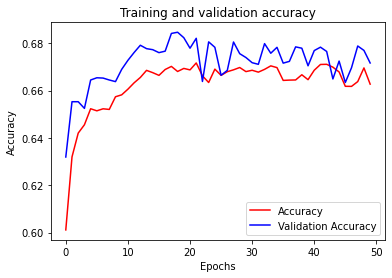

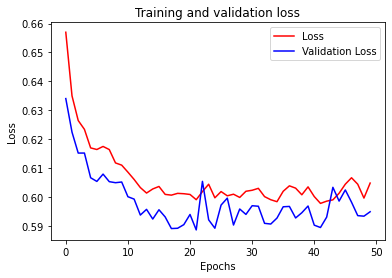

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()


plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()